In [1]:
import numpy as np
import shutil
import time
import matplotlib.pyplot as plt

In [8]:
train_pth = "/archive/train"
test_pth = "/archive/test"

classes = os.listdir(train_pth)
print(classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
batch = 32
split = 0.1
col = 48
row = 48
size = (row, col)
shear = 0.3
rotat = 20
w_shift = 0.4
h_shift = 0.4
zoom = 0.2

Data Augmentation

In [25]:
gen_train = ImageDataGenerator(rescale=1./255, zoom_range=zoom, rotation_range=rotat, shear_range=shear, 
width_shift_range=w_shift, height_shift_range=h_shift, horizontal_flip=True, fill_mode='nearest')

gen_test = ImageDataGenerator(rescale=1./255, zoom_range=zoom, rotation_range=rotat, shear_range=shear, 
width_shift_range=w_shift, height_shift_range=h_shift, horizontal_flip=True, fill_mode='nearest')


train_batches = gen_train.flow_from_directory(directory=train_pth, color_mode='grayscale', target_size=size, batch_size=batch, class_mode='categorical', shuffle=True)
test_batches = gen_test.flow_from_directory(directory=test_pth, color_mode='grayscale', target_size=size, batch_size=batch, classes=classes, shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [26]:
imgs, labels = next(train_batches)

In [30]:
def plt_imgs(img_arr):
    fig, axes = plt.subplots(1, batch, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [28]:
train_batches.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

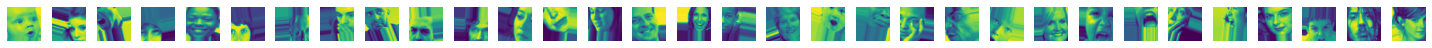

[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [31]:
plt_imgs(imgs)
print(labels)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix

Model Architecture

In [33]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding= 'same', input_shape=((col, row, 1)) ),
    MaxPool2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding= 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Dropout(0.2),


    Flatten(), 
    Dense(units=1024, activation='relu'),
    BatchNormalization(), Dropout(0.5),
    Dense(units=7, activation='softmax'),
])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 12, 64)       

Using Model Checkpoint to save the model only at the best Accuracy during training

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkp = ModelCheckpoint('emotion_det.h5', monitor='val_accuracy', min_delta=0, mode='max', patience=0, verbose=1, save_best_only=True)
# early_s = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=0, verbose=1, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=0,  verbose=1, min_delta=0.0001)

callback = [checkp]

In [36]:
model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

I Later Increased epochs to 600, and that increased evaluation accuracy to 64%, 

In [37]:
epochs = 30
hist = model.fit(x=train_batches, validation_data=test_batches, epochs=epochs, callbacks=callback, verbose=1)

Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 2.6932 - accuracy: 0.1789
Epoch 00001: val_accuracy improved from -inf to 0.22123, saving model to emotion_det.h5
898/898 [==============================] - 3317s 4s/step - loss: 2.6932 - accuracy: 0.1789 - val_loss: 1.8899 - val_accuracy: 0.2212
Epoch 2/30
898/898 [==============================] - ETA: 0s - loss: 2.3335 - accuracy: 0.2020
Epoch 00002: val_accuracy improved from 0.22123 to 0.23363, saving model to emotion_det.h5
898/898 [==============================] - 2837s 3s/step - loss: 2.3335 - accuracy: 0.2020 - val_loss: 1.8362 - val_accuracy: 0.2336
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 2.2014 - accuracy: 0.2057
Epoch 00003: val_accuracy improved from 0.23363 to 0.24937, saving model to emotion_det.h5
898/898 [==============================] - 2097s 2s/step - loss: 2.2014 - accuracy: 0.2057 - val_loss: 1.8196 - val_accuracy: 0.2494
Epoch 4/30
898/898 [=======================

In [38]:
hist.history??


Type:        dict
String form: {'loss': [2.6931614875793457, 2.333481788635254, 2.201390027999878, 2.0928502082824707, 2.0222458839416504, 1.9667328596115112, 1.9119839668273926, 1.880116581916809, 1.8473436832427979, 1.8227370977401733, 1.7977219820022583, 1.7805882692337036, 1.7693140506744385, 1.7400150299072266, 1.7233636379241943, 1.7106555700302124, 1.6901408433914185, 1.6729207038879395, 1.663559913635254, 1.6491070985794067, 1.6354507207870483, 1.6208019256591797, 1.6060564517974854, 1.5994575023651123, 1.58383047580719, 1.5771914720535278, 1.5671484470367432, 1.5493849515914917, 1.5480848550796509, 1.5405794382095337], 'accuracy': [0.1788637638092041, 0.20202723145484924, 0.205719456076622, 0.20878469944000244, 0.21787592768669128, 0.22533003985881805, 0.23302796483039856, 0.24170121550559998, 0.25141942501068115, 0.2565746009349823, 0.266501784324646, 0.2770211398601532, 0.28235048055648804, 0.2940889596939087, 0.3040509819984436, 0.314883828163147, 0.32178062200546265, 0.330

In [39]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There's a fairly consistent rise in evaluation accuracy across epochs, so based on this, theres a a fair chance of further increasing Overall model performance. 

No handles with labels found to put in legend.


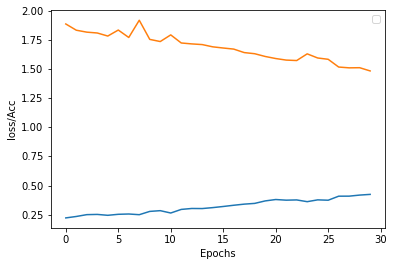

In [45]:
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("loss/Acc")


In [42]:
test_batches.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

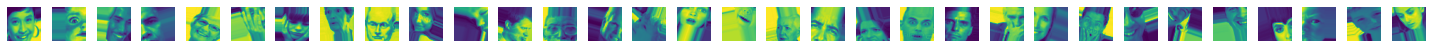

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


In [43]:
t_img, t_lab = next(test_batches)
plt_imgs(t_img)
print(t_lab)

In [46]:
prediction = model.predict(x=test_batches, verbose=0)
np.round(prediction)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
cm = confusion_matrix(y_true= test_batches.classes, y_pred= np.argmax(prediction, axis=-1))

At 42% evaluation accuracy, the confusion matrix shows a poor perfomance on the model.

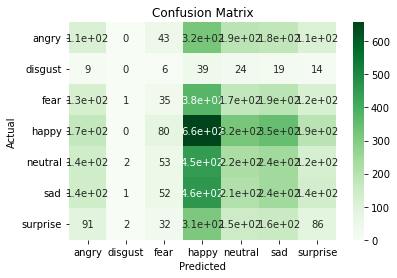

In [48]:
import seaborn as sns

sns.heatmap(cm, cmap="Greens", annot=True, xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()